# Pathway Analysis with PathSingle

In [1]:
%reload_ext autoreload
%autoreload 2
import scanpy as sc
import pandas as pd
import scanpy.external as sce
from metrics import *
from activity import *

from warnings import filterwarnings
filterwarnings('ignore')


sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 numpy==1.26.4 scipy==1.13.1 pandas==2.0.3 scikit-learn==1.5.0 statsmodels==0.14.2 pynndescent==0.5.12


### Data Preparation
The challenge data is available on AWS cloud servers. You need to register to the challenge here:
- https://www.topcoder.com/challenges/25f60820-2e69-444b-bc03-490686af2c87?tab=details

and then go the the forum links and download sc_training.h5ad from:

- https://discussions.topcoder.com/discussion/25381/challenge-specifications-and-data-for-cancer-immunotherapy-data-science-grand-challenge

In [2]:
adata = sc.read_h5ad('./data/sc_training.h5ad')
#28697 cells × 15077 genes.
adata

AnnData object with n_obs × n_vars = 28697 × 15077
    obs: 'gRNA_maxID', 'state', 'condition', 'lane'
    layers: 'rawcounts'

In [ ]:
# adata.X stores the stadard-normalized data, but you can also reconstruct it using adata.layers['rawcounts']
# make a copy of normalized logcounts
#adata.layers['normalized_logcounts'] = adata.X.copy()
# standard normalization
#adata.X = adata.layers['rawcounts'].copy()

#sc.pp.normalize_total(adata, target_sum=5e3)
#sc.pp.log1p(adata)

#adata.raw.X[:5,:5].toarray()

### Data exploration

In [3]:
adata.obs.head()

,gRNA_maxID,state,condition,lane
053l1_AAACCTGAGATGTCGG-1,ONE-NON-GENE-SITE-7,terminal exhausted,Unperturbed,lane1
053l1_AAACCTGAGCAACGGT-1,Tox2-3,effector,Tox2,lane1
053l1_AAACCTGAGTACGACG-1,Tpt1-2,effector,Tpt1,lane1
053l1_AAACCTGAGTCGTTTG-1,Tox2-3,terminal exhausted,Tox2,lane1
053l1_AAACCTGAGTGAAGAG-1,Tcf7-2,effector,Tcf7,lane1


### Run Magic

In [3]:
%%time
print(adata.X[:1,:5].toarray())
sce.pp.magic(adata, name_list='all_genes', knn=5)
print(adata.X[:1,:5])

[[0.5115199 0.        0.        0.        0.       ]]
computing MAGIC
  Running MAGIC with `solver='exact'` on 15077-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
    finished (0:09:37)
[[0.40064804 0.25801364 0.51226141 0.16964659 0.13582279]]
CPU times: total: 5min 33s
Wall time: 9min 37s


In [4]:
print(adata.obs_names[:5])
print(adata.var_names[:5])

Index(['053l1_AAACCTGAGATGTCGG-1', '053l1_AAACCTGAGCAACGGT-1',
       '053l1_AAACCTGAGTACGACG-1', '053l1_AAACCTGAGTCGTTTG-1',
       '053l1_AAACCTGAGTGAAGAG-1'],
      dtype='object')
Index(['Mrpl15', 'Lypla1', 'Tcea1', 'Atp6v1h', 'Rb1cc1'], dtype='object')


### Run PathSingle

In [16]:
calc_activity_from_adata(adata)

 53%|█████▎    | 165/314 [6:58:13<8:52:54, 214.59s/it] 

### Cluster With KMeans

In [27]:
bdata = sc.read_csv('./data/output_activity_st3.csv')
print(bdata.obs_names[:5]) #The observations have to be the cell names.
print(bdata.var_names[:5]) #The variables have to be the pathways names.

Index(['053l1_AAACCTGAGATGTCGG-1', '053l1_AAACCTGAGCAACGGT-1',
       '053l1_AAACCTGAGTACGACG-1', '053l1_AAACCTGAGTCGTTTG-1',
       '053l1_AAACCTGAGTGAAGAG-1'],
      dtype='object')
Index(['1 4-Dichlorobenzene degradation(Kegg)',
       '1- and 2-Methylnaphthalene degradation(Kegg)',
       '3-Chloroacrylic acid degradation(Kegg)',
       'Acute myeloid leukemia(Kegg)', 'Adherens junction(Kegg)'],
      dtype='object')


computing PCA
    with n_comps=50
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


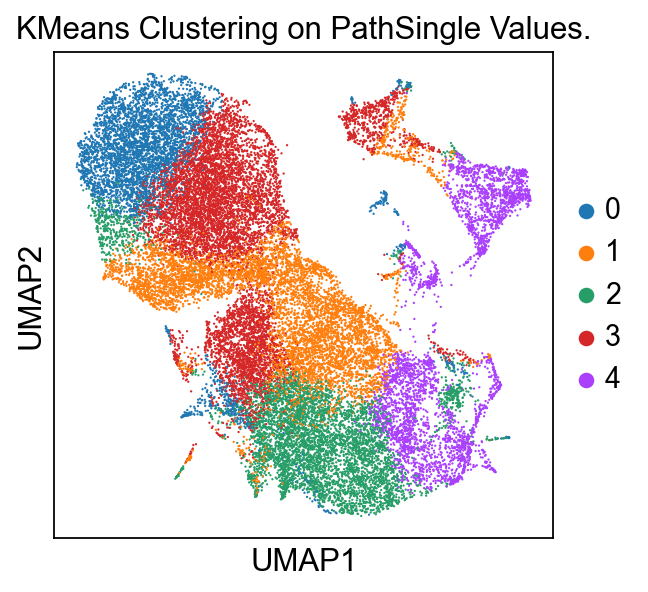

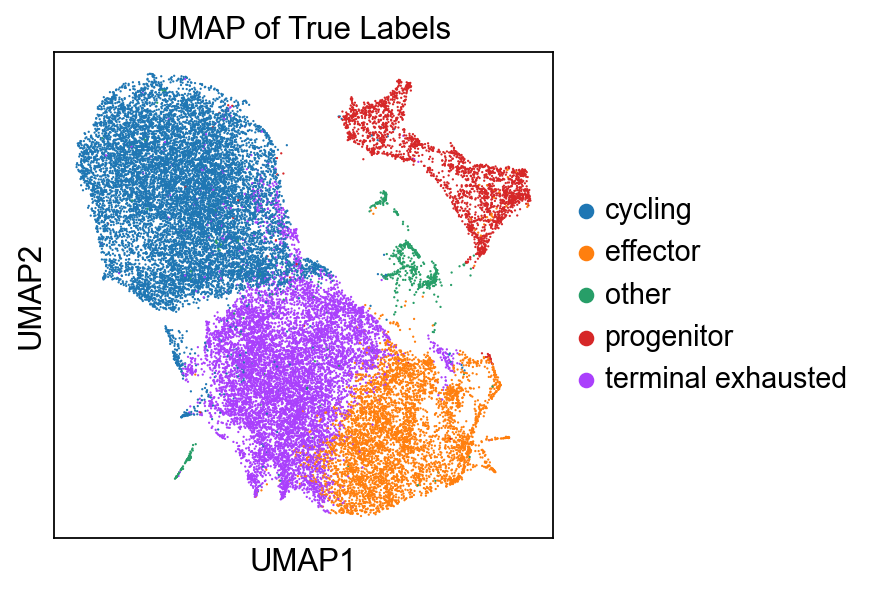

CPU times: total: 46.6 s
Wall time: 49.6 s


In [28]:
%%time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap


# Scale the data
scaler = StandardScaler()
bdata.X = scaler.fit_transform(bdata.X)

# Perform PCA for Dimensionality Reduction
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

#Perform KMeans clustering.
kmeans = KMeans(n_clusters=5, random_state=0).fit(bdata.X)
bdata.obs['kmeans'] = pd.Categorical(kmeans.labels_)

#Perform PCA and UMAP.
#umap_model = umap.UMAP(n_neighbors=15, random_state=0)
#umap_coords = umap_model.fit_transform(df)
sc.tl.pca(bdata, svd_solver='arpack')
sc.pp.neighbors(bdata, n_neighbors=30, n_pcs=50)
sc.tl.umap(bdata, min_dist=0.3)

#Add the UMAP coordinates and clustering results to the AnnData object.
#bdata.obs['X_umap'] = bdata.obsm['X_umap']
#adata.obs['kmeans4'] = pd.Categorical(kmeans.labels_)

#Add the true labels from the original 'adata'.
bdata.obs['state'] = adata.obs.state

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(bdata, color=["kmeans"], title="KMeans Clustering on PathSingle Values.")
sc.pl.umap(bdata, color=["state"], title="UMAP of True Labels")
#sc.pl.umap(bdata, color=['state'], palette='Accent', legend_loc='right margin')

In [29]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = bdata.X

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
#dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
#print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(acc(adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_))

Silhouette Score: 0.13966581225395203
Calinski-Harabasz Index: 4833.945701314397
0.40906714987629367
CPU times: total: 1min 11s
Wall time: 24.9 s


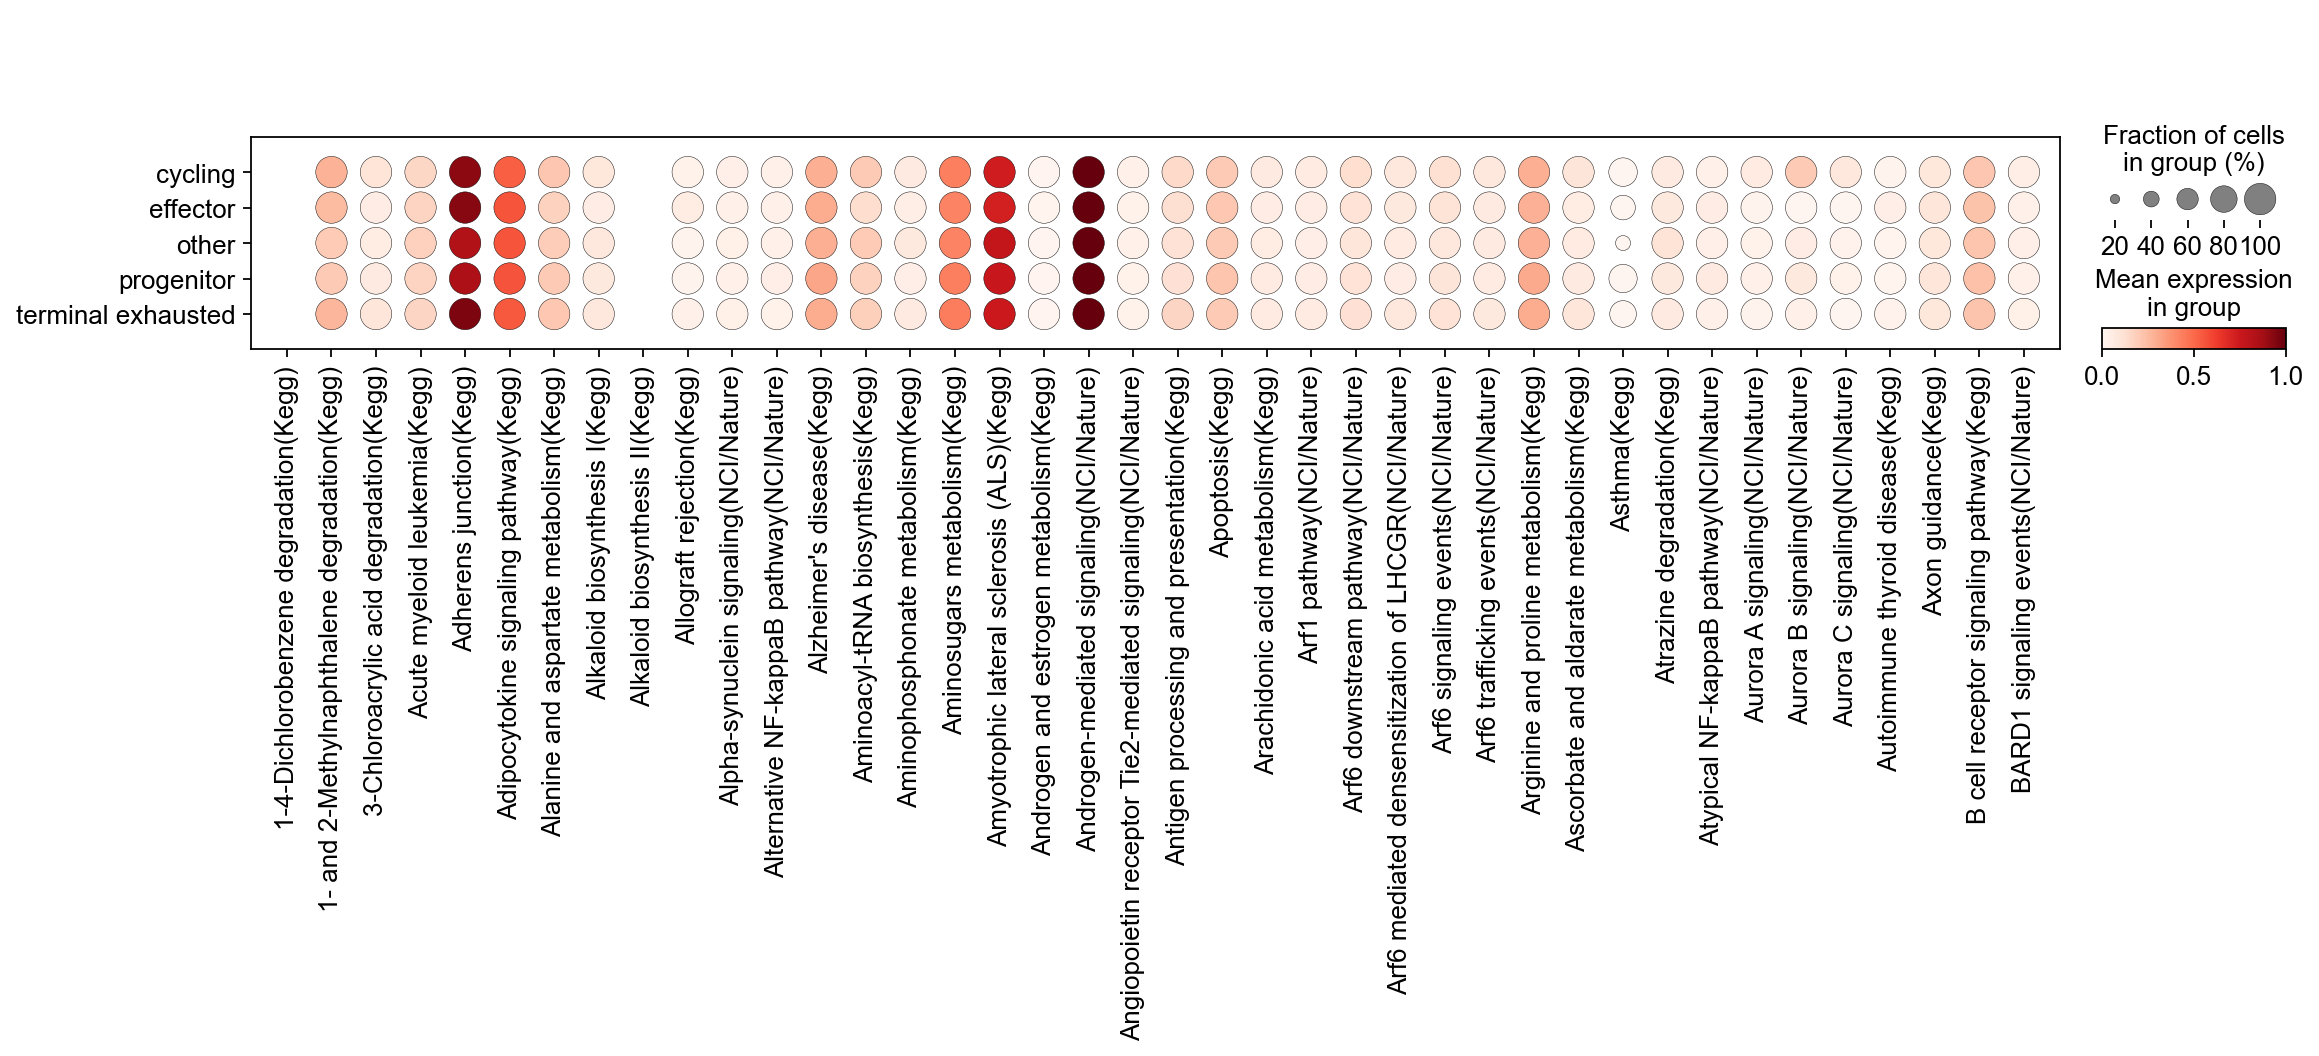

In [24]:
var_names = bdata.var_names[0:40]
sc.pl.dotplot(bdata, var_names=var_names, groupby='state')

## PROGENy

In [3]:
import decoupler


progeny = decoupler.get_progeny(organism='human', top=500)
progeny.head()

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40


In [16]:
# Normalize gene names to lowercase
adata.var_names = [gene.lower() for gene in adata.var_names]
progeny['target'] = progeny['target'].str.lower()

# Inspect unique gene names in both datasets
unique_adata_genes = set(adata.var_names)
unique_progeny_genes = set(progeny['target'])

# Check overlap
shared_targets = unique_adata_genes & unique_progeny_genes
print(f"Number of shared targets: {len(shared_targets)}")
print(f"Number of unique genes in adata: {len(unique_adata_genes)}")
print(f"Number of unique genes in progeny: {len(unique_progeny_genes)}")

# Identify missing genes
missing_in_progeny = unique_adata_genes - unique_progeny_genes
missing_in_adata = unique_progeny_genes - unique_adata_genes
print(f"Genes in adata but not in progeny: {len(missing_in_progeny)}")
print(f"Genes in progeny but not in adata: {len(missing_in_adata)}")

Number of shared targets: 4009
Number of unique genes in adata: 15077
Number of unique genes in progeny: 5699
Genes in adata but not in progeny: 11068
Genes in progeny but not in adata: 1690


In [17]:
print("Example genes in adata but not in progeny:", list(missing_in_progeny)[:10])
print("Example genes in progeny but not in adata:", list(missing_in_adata)[:10])

Example genes in adata but not in progeny: ['gm20559', 'gal3st1', 'gm15952', 'ndufs6', 'cggbp1', 'ccr2', 'ralgps1', 'ocrl', 'adcy3', 'eif2s3y']
Example genes in progeny but not in adata: ['csta', 'plxna4', 'camlg', 'trim40', 'cap2', 'tnc', 'cxcl6', 'krt25', 'nme5', 'rnase2']


In [18]:
# Filter mat to include only shared targets
filtered_mat = adata[:, list(shared_targets)].copy()

# Check for empty features
non_empty_features = filtered_mat[:, filtered_mat.X.sum(axis=0) > 0]

# Run PROGENy with the filtered matrix
try:
    decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False
    )
except ValueError as e:
    print(e)
    print("Adjusting min_n parameter...")
    decoupler.run_mlm(
        mat=non_empty_features,
        net=progeny,
        source='source',
        target='target',
        weight='weight',
        verbose=True,
        use_raw=False,
        min_n=1  # Adjust this parameter as needed
    )


Running mlm on mat with 28697 samples and 4007 targets for 14 sources.


100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


### Cluster With KMeans

Pathway activity matrix shape: (28697, 14)


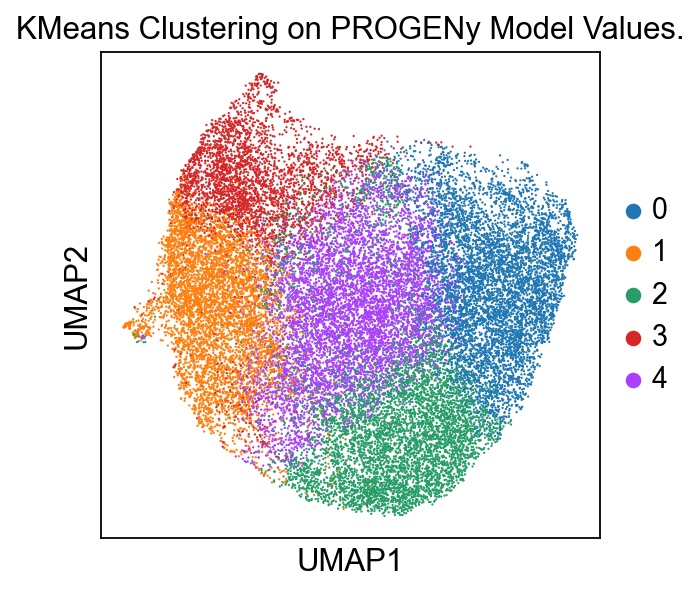

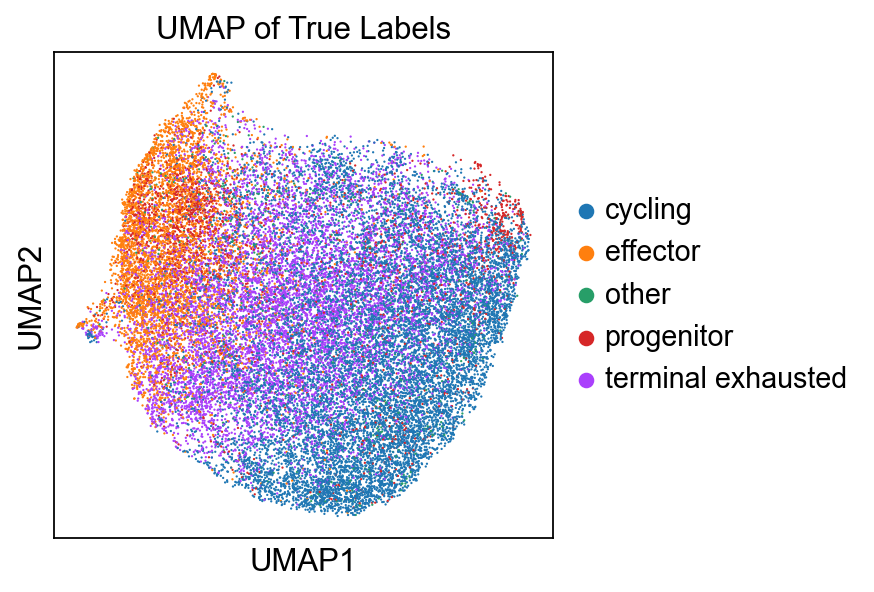

In [22]:
from sklearn.cluster import KMeans
import umap.umap_ as umap


acts = decoupler.get_acts(non_empty_features, obsm_key='mlm_estimate')

#Verify the structure of pathway activity matrix.
print("Pathway activity matrix shape:", acts.obsm['mlm_estimate'].shape)

#Convert the pathway activity matrix to a DataFrame.
pathway_activity_df = pd.DataFrame(
    acts.obsm['mlm_estimate'],
    index=adata.obs_names,
    columns=acts.var_names
)

#Add pathway activity to adata.obs.
#for pathway in acts.var_names:
    #adata.obs[pathway] = pathway_activity_df[pathway]

#Perform KMeans clustering on the UMAP coordinates.
kmeans = KMeans(n_clusters=5, random_state=0).fit(pathway_activity_df)

#Perform UMAP on the GSEA results matrix.
umap_model = umap.UMAP(n_neighbors=15) #For reproducability need to set , random_state=0, n_jobs=1.
umap_coords = umap_model.fit_transform(pathway_activity_df)

#Add the UMAP coordinates and clustering results to the AnnData object.
adata.obsm['X_umap'] = umap_coords
adata.obs['kmeans3'] = pd.Categorical(kmeans.labels_)

#Plotting UMAP with KMeans clustering results using scanpy.
sc.pl.umap(adata, color=["kmeans3"], title="KMeans Clustering on PROGENy Model Values.")
sc.pl.umap(adata, color=["state"], title="UMAP of True Labels")

### Cluster Results

In [26]:
%%time
#Extract pathway activity matrix for metric calculation.
pathway_activity_matrix = acts.obsm['mlm_estimate']

#Silhouette score.
silhouette_avg = silhouette_score(pathway_activity_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

#Calinski-Harabasz index.
calinski_harabasz = calinski_harabasz_score(pathway_activity_matrix, kmeans.labels_)
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

#Dunn index.
dunn = dunn_index(pathway_activity_matrix, kmeans.labels_)
print(f"Dunn Index: {dunn}")

#Special accuracy function.
print(acc(adata.obs.state.map({'cycling':0, 'effector':1, 'other':2, 'progenitor':3, 'terminal exhausted':4}), kmeans.labels_))

Silhouette Score: 0.10964662581682205
Calinski-Harabasz Index: 4611.1675632659235
Dunn Index: 0.04010670817222
0.43809457434575044
CPU times: total: 50.9 s
Wall time: 3min 44s
